In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts

import requests
import json
import time

USE_SIMULATION = True

In [2]:
tf.compat.v1.enable_v2_behavior()


In [3]:
tf.version.VERSION


'2.2.0'

In [4]:
num_iterations = 200000 # @param {type:"integer"}

initial_collect_steps = 10  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 16  # @param {type:"integer"}
learning_rate = 1e-5  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


## Helper functions for the real kettle

In [5]:
def observe_kettle():
    # TODO remove the offset!!
    resp = requests.get("http://192.168.178.87/")
    a = json.loads(resp.text)
    temperatures = [x[1]-50.0 for x in json.loads(resp.text)["temp"]]
    on_off = [float(x[1]) for x in json.loads(resp.text)["state"]]
    return temperatures+on_off

def turn_kettle_on():    
    resp = requests.get("http://192.168.178.87/r_on")
    
def turn_kettle_off():    
    resp = requests.get("http://192.168.178.87/r_off")

    
# observation = observe_kettle()
# print(observation)

## Simulated kettle environment

In [6]:


class KettleEnv(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(shape=(20,), dtype=np.float32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    # TODO print something for me to clean out the kettle...
    self._state = observe_kettle()
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):
    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start a new episode.
      return self.reset()

    # Make sure episodes don't go on forever.
    if action == 1:
        turn_kettle_on()
    elif action == 0:
        turn_kettle_off()
    else:
      raise ValueError('`action` should be 0 or 1.')

    # TODO do I have to sleep here or somewhere else...
    time.sleep(1.0)
    
    self._state = observe_kettle()

    current_temp = self._state[9]
    print("Current temp", current_temp)
    given_reward = 0.0
    if current_temp < 0:
        given_reward = 1.0-0.0*abs(current_temp)
    else:
        given_reward = 1.0-0.03*abs(current_temp)
    
    return ts.transition(np.array(self._state, dtype=np.float32), reward=given_reward, discount=1.0)



class SimulatedKettleEnv(py_environment.PyEnvironment):
  def __init__(self):    
    self.action_history_seconds = 100
    self.set_temperature = 50.0
        
    # Actions the neural network can take. In this caes it's either 0 or 1. 
    self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    
    # The observations the neural network makes. In this case it consists of: 
    #   * a certain length of history in temperatures in seconds
    #   * a certain length of history in temperatures in action-performed (0 or 1)
    self._observation_spec = array_spec.BoundedArraySpec(shape=(2*self.action_history_seconds,), dtype=np.float32, minimum=0, name='observation')

    # Some other things. 
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _update_state(self):
            # The current state consists of two things: 
#     self._state = self.water_history[-self.action_history_seconds:] + self.action_history[-self.action_history_seconds:]
    self._state = [0.01*(x-self.set_temperature) for x in self.water_history[-self.action_history_seconds:]] + self.action_history[-self.action_history_seconds:]
    
  def _reset(self):
    print("Resetting the kettle")
    # Reset the model of the rod and the water
    self.temperature_rod = 20.0
    self.temperature_water = 20.0
    
    # Reset the parameters which determine the state
    self.water_history = [self.temperature_water]*self.action_history_seconds
    self.action_history = [0.0]*self.action_history_seconds # pretend we did not do anything for a while
    
    self._update_state()

    
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):
    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start a new episode.
      return self.reset()

    # TODO implement a better mathematical model, such as this one: https://www.ijesm.co.in/uploads/68/5720_pdf.pdf
    if action == 1:
        self.temperature_water += 0.1
    elif action == 0:
        # don't do anything, rod will cool down anyways
        self.temperature_water -= 0.1
    else:
      raise ValueError('`action` should be 0 or 1.')

    
    # Add the temperature of the water and the performed action
    self.water_history.append(self.temperature_water)
    self.action_history.append(float(action))
    
    self._update_state()
    
    # TODO Very ugly way to get the temperature to set_temp degrees...
#     print("Current temp", self.temperature_water, ' action was ', action)
    current_temp = self.temperature_water - self.set_temperature


    given_reward = 0.0
    if current_temp < 0:
        given_reward = 1.0-0.01*abs(current_temp)
    else:
        given_reward = 1.0-0.03*abs(current_temp)
    
    if self.temperature_water > 90.0 or self.temperature_water < 0.0:
        # This is too hot, better cool down a bit
        self._episode_ended = True
        return ts.termination(np.array(self._state, dtype=np.float32), given_reward)
    else:
        return ts.transition(np.array(self._state, dtype=np.float32), reward=given_reward, discount=1.0)
    
if USE_SIMULATION:
    env = SimulatedKettleEnv()
else:
    env = KettleEnv()
    

Resetting the kettle
0.701
0.702
0.703
0.704
0.705
0.706
0.707
0.708
0.709
0.71
0.711
0.712
0.713
0.714
0.715
0.716
0.717
0.718
0.719
0.72
0.721
0.722
0.723
0.724
0.725
0.726
0.727
0.728
0.729
0.73
0.731
0.732
0.733
0.734
0.735
0.736
0.737
0.738
0.739
0.74
0.741
0.742
0.743
0.744
0.745
0.746
0.747
0.748
0.749
0.75
0.751
0.752
0.753
0.754
0.755
0.756
0.757
0.758
0.759
0.76
0.761
0.762
0.763
0.764
0.765
0.766
0.767
0.768
0.769
0.77
0.771
0.772
0.773
0.774
0.775
0.776
0.777
0.778
0.779
0.78
0.781
0.782
0.783
0.784
0.785
0.786
0.787
0.788
0.789
0.79
0.791
0.792
0.793
0.794
0.795
0.796
0.797
0.798
0.799
0.8
0.801
0.802
0.803
0.804
0.805
0.806
0.807
0.808
0.809
0.81
0.811
0.812
0.813
0.814
0.815
0.816
0.817
0.818
0.819
0.82
0.821
0.822
0.823
0.824
0.825
0.826
0.827
0.828
0.829
0.83
0.831
0.832
0.833
0.834
0.835
0.836
0.837
0.838
0.839
0.84
0.841
0.842
0.843
0.844
0.845
0.846
0.847
0.848
0.849
0.85
0.851
0.852
0.853
0.854
0.855
0.856
0.857
0.858
0.859
0.86
0.861
0.862
0.863
0.864
0.865
0.866


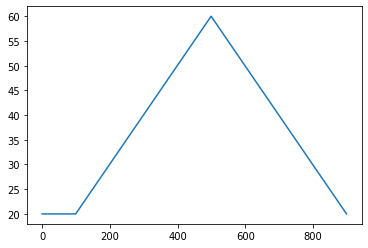

In [7]:
ket = SimulatedKettleEnv()
ket.reset()
for i in range(400):
    result = ket.step(1)
    print(result.reward)
for i in range(400):
    result = ket.step(0)
plt.plot(ket.water_history)
    

In [8]:
env.reset()


Resetting the kettle


TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
  

In [9]:
print('Observation Spec:')
print(env.time_step_spec().observation)


Observation Spec:
BoundedArraySpec(shape=(200,), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=3.4028234663852886e+38)


In [10]:
print('Reward Spec:')
print(env.time_step_spec().reward)


Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [11]:
print('Action Spec:')
print(env.action_spec())


Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=1)


In [12]:
if USE_SIMULATION:
    train_py_env = SimulatedKettleEnv()
    eval_py_env = SimulatedKettleEnv()
else:
    train_py_env = KettleEnv()
    eval_py_env = KettleEnv()

In [13]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [14]:
fc_layer_params = (30,10,5)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


In [15]:
q_net

In [16]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy = 0.3,
    td_errors_loss_fn=common.element_wise_huber_loss,
    train_step_counter=train_step_counter)

agent.initialize()


In [17]:
eval_policy = agent.policy
collect_policy = agent.collect_policy


In [18]:
if USE_SIMULATION:
    example_environment = tf_py_environment.TFPyEnvironment(SimulatedKettleEnv())
else:
    example_environment = tf_py_environment.TFPyEnvironment(KettleEnv())

In [19]:
time_step = example_environment.reset()

Resetting the kettle


In [20]:
# def compute_avg_return(environment, policy, num_episodes=10):

def compute_avg_return(environment, policy, num_steps = 100):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]



In [21]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)


In [22]:

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

    
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
collect_data(train_env, random_policy, replay_buffer, steps=10000)

Resetting the kettle


In [23]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset


<PrefetchDataset shapes: (Trajectory(step_type=(16, 2), observation=(16, 2, 200), action=(16, 2), policy_info=(), next_step_type=(16, 2), reward=(16, 2), discount=(16, 2)), BufferInfo(ids=(16, 2), probabilities=(16,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [24]:
iterator = iter(dataset)


In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

print("Reset the train step")
agent.train_step_counter.assign(0)

print("Evaluate the agent's policy once before training.")
# avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
# returns = [avg_return]

for current_iteration in range(num_iterations):
#       agent.collect_policy._epsilon = 1.0
#     try:
    #   print("Collect a few steps using collect_policy and save to the replay buffer.")
      for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    #   print("Sample a batch of data from the buffer and update the agent's network.")
      experience, unused_info = next(iterator)
      train_loss = agent.train(experience).loss
      step = agent.train_step_counter.numpy()
    #   print("Step is ", step)


      if step % log_interval == 0:
        print('step = {0}: loss = {1}, learning from {2}'.format(step, train_loss, replay_buffer.num_frames().numpy()))
        print("Temperature is", train_py_env.temperature_water)

    #   if step % eval_interval == 0:
    #     avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    #     print('step = {0}: Average Return = {1}'.format(step, avg_return))
    #     returns.append(avg_return)
    #     except Exception as e:
    #         print("Damn you kettle")
    #         print(e)
    #         time.sleep(3.0)

Reset the train step
Evaluate the agent's policy once before training.
step = 1000: loss = 0.22157081961631775, learning from 11000
Temperature is 13.599999999999953
step = 2000: loss = 0.24307942390441895, learning from 12000
Temperature is 65.20000000000056
step = 3000: loss = 0.2309722602367401, learning from 13000
Temperature is 64.00000000000063
step = 4000: loss = 0.26344847679138184, learning from 14000
Temperature is 33.000000000000185
Resetting the kettle
Resetting the kettle
step = 5000: loss = 0.3094533085823059, learning from 15000
Temperature is 8.99999999999997
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
step = 6000: loss = 0.24914319813251495, learning from 16000
Temperature is 16.39999999999995
Resetting the kettle
Resetting the kettle
Resetting the kettle
step = 7000: loss = 0.46439069509506226, learning from 17000
Temperature is 11.099999999999962
Resetting the kettle
Resetting the kettle
Resetting the kettle
step = 8000: loss =

In [ ]:
dir(replay_buffer)

In [ ]:
blaat = next(iterator)

In [ ]:
blaat

In [ ]:
a = KettleEnv()

In [ ]:
observed = replay_buffer.gather_all().observation.numpy()

In [ ]:
plt.plot(observed[0])

In [ ]:
plt.plot(replay_buffer.gather_all().reward.numpy()[0])

In [ ]:
dir(agent)